Ce notebook a été préparé par Fabien Moutarde (MINES ParisTech) en modifiant/combinant 2 notebooks de Cambridge : http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits
http://online.cambridgecoding.com/notebooks/cca_admin/convolutional-neural-networks-with-keras


## Introduction

The goal of this practical session is to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details, with the purposes of achieving respectable performance on one established machine learning benchmark: [MNIST](http://yann.lecun.com/exdb/mnist/) (classification of hand-written digits).


MNIST hand-written digits dataset                      
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  

By the end of this part of thi practical session, you should be capable of understanding and producing a simple ConvNet (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on MNIST.


## Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

## Convolutional and pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a ConvNet. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a ConvNet (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)

## Putting it all together: a typical ConvNet architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical ConvNet architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

The softmax layer and cross-entropy loss are both introduced in more detail [in another tutorial](http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits). For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.

## Detour: Overfitting, regularisation and dropout

This will be the first (and hopefully the only) time when I will divert your attention to a seemingly unrelated topic. It regards a very important pitfall of machine learning---**overfitting** a model to the training data. While this is primarily going to be a major topic of the next tutorial in the series, the negative effects of overfitting will tend to become quite noticeable on the networks like the one we are about to build, and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points: 

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method I will introduce here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## Applying a deep ConvNet to MNIST

As this post's objective, we will implement a deep convolutional neural network---and apply it on the MNIST digit recognition classification task.


As already mentioned, a ConvNet will typically have more hyperparameters than an MLP. For the purposes of this tutorial practical session, we will also stick to "sensible" hand-picked values for them, but do still keep in mind that later on I will introduce a more proper method for learning them.

The hyperparameters are:
- The *batch size*, representing the number of training examples being used simultaneously during a single iteration of the gradient descent algorithm;
- The number of *epochs*, representing the number of times the training algorithm will iterate over the entire training set before terminating\*;
- The *kernel sizes* in the convolutional layers;
- The *pooling size* in the pooling layers;
- The *number of kernels* in the convolutional layers;
- The *dropout probability* (we will apply dropout after each pooling, and after the fully connected layer);
- The *number of neurons* in the fully connected layer of the MLP.



Modelling time! Our network has an architecture similar to LeNet5 of LeCun (see figure below). It will consist of two consecutive groups of one `Convolution2D` followed by  a `MaxPooling2D` layer. After the first pooling layer, the number of kernels is rougly doubled (in line with the previously mentioned principle of sacrificing height and width for more depth). Afterwards, the output of the second pooling layer is flattened to 1D (via the `Flatten` layer), and passed through one or two fully connected (`Dense`) layers. ReLU activations will once again be used for all layers except the output dense layer, which will use a softmax activation (for purposes of probabilistic classification).

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lenet5.png)

To regularise our model, a `Dropout` layer is applied after each pooling layer, and after the first `Dense` layer. This is another area where Keras shines compared to other frameworks: it has an internal flag that automatically enables or disables dropout, depending on whether the model is currently used for training or testing.

The remainder of the model specification is the following:
- We use the *cross-entropy* loss function as the objective to optimise (as its derivation is more appropriate for probabilistic tasks);
- We use the [*Adam* optimiser for gradient descent](http://sebastianruder.com/optimizing-gradient-descent/);
- We report the *accuracy* of the model (as the dataset is balanced across the ten classes)\*;
- We hold out a significant proportion of the data for validation purposes.

\* To get a feeling for why accuracy might be inappropriate for unbalanced datasets, consider an extreme case where 90% of the test data belongs to class $x$ (this could be, for example, the task of diagnosing patients for an extremely rare disease). In this case, a classifier that just outputs $x$ achieves a seemingly impressive accuracy of 90% on the test data, without really doing any learning/generalisation.

This model, possibly after some tweaking of its architectural parameters, should be able to break $99\%$ accuracy on its **test set** with little to no effort.


## Conclusion

Throughout this post we have covered the essentials of convolutional neural networks, introduced the problem of overfitting, and made a very brief dent into how it could be rectified via regularisation (by applying dropout) and successfully implemented a two-layer deep ConvNet (with LeNet like architecture) in Keras, applying it to MNIST, all in under 50 lines of code. 


## Just show me the code!

In [1]:
import os
# FIRST CHOOSE WHICH "BACK-END" YOU WILL USE, BETWEEN tensorflow (preferable) OR theano
#    (depending on which you have managed to install)
os.environ['KERAS_BACKEND']="tensorflow"
import tensorflow
print("Version tensorflow :" + tensorflow.__version__)
#os.environ['KERAS_BACKEND']="theano"
#import theano
#print("Version Theano :" + theano.__version__)


# WHATEVER BACK-END YOU HAVE CHOSEN, YOU SHALL USE keras AS RONT-END
import keras
print("Version KERAS :" + keras.__version__)

from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten


from keras import regularizers


from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
from numpy import newaxis



# CONVNET PARAMETERS
# ===================
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 13 # we iterate ?? times over the entire training set
kernel_size = 5 # we will use 5x5 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 6 # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.# dropout after pooling with probability ??
drop_prob_2 = 0. # dropout in the FC layer with probability ??
hidden_size = 128 # the FC layer will have 128 neurons
weight_penalty = 0.0 # Factor for weights penalty



# DATASET CHARACTERISTICS
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000 # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 and *greyscale*
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

# REFORMAT PROPERLY THE DATA
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range
X_train = X_train[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels
print(X_train.shape)
print(Y_train.shape)

# NOW, BUILD THE MODEL ARCHITECTURE
# =================================

model = Sequential()
# FIRST CONVOLUTION+POOLING LAYERS
#   Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', 
                         data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# FIRST CONVOLUTION+POOLING LAYERS
#    Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# CLASSIFICATION PART: FULLY-CONNECTED LAYER + OUTPUT LAYER
#   Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) ) # Some Dropout regularization (if necessary)
model.add( Dense(num_classes, activation='softmax') )

# DISPLAY THE MODEL ARCHITECTURE INFORMATION
print(model.summary)

# DEFINE THE LOSS FUNCTION AND OPTIMIZER
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# TRAIN THE MODEL
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.6) # ...holding out 40% of the data for validation

# EVALUATE THE MODEL ON TEST SET
print("\n EVALUATION [loss, accuracy] on TEST set:")
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!


/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Version tensorflow :1.11.0
Version KERAS :2.2.4


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(60000, 1, 28, 28)
(60000, 10)


/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28..., padding="same")`
/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0xb22e14be0>>
Train on 24000 samples, validate on 36000 samples
Epoch 1/13
24000/24000 [==============================] - 24s 1ms/step - loss: 0.3759 - acc: 0.8887 - val_loss: 0.1724 - val_acc: 0.9486
Epoch 2/13
24000/24000 [==============================] - 24s 997us/step - loss: 0.1395 - acc: 0.9558 - val_loss: 0.1197 - val_acc: 0.9634
Epoch 3/13
24000/24000 [==============================] - 25s 1ms/step - loss: 0.1001 - acc: 0.9698 - val_loss: 0.1204 - val_acc: 0.9631
Epoch 4/13
24000/24000 [==============================] - 24s 992us/step - loss: 0.0807 - acc: 0.9741 - val_loss: 0.1220 - val_acc: 0.9607
Epoch 5/13
24000/24000 [==============================] - 24s 1ms/step - loss: 0.0663 - acc: 0.9797 - val_loss: 0.0871 - val_acc: 0.9739
Epoch 6/13
23936/24000 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9818

KeyboardInterrupt: 

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

**You should see that over-fitting begins to occur.<br> 
Question 1: WHAT IS THE SIGN OF OVER-FITTING ON ABOVE GRAPH?<br>
Answer: <br>
<br>
There are 2 different methods that can be used to prevent over-fitting.<br>
Question 2: WHAT ARE THOSE 2 OVER-FITTING PREVENTION METHODS?<br>
Answer :<br>
<br>
Test those 2 methods SEPARATELY below, by copy-pasting the original code, modifying it, and running it. <br>**

**Final assignment: in code cell below, by applying a good combination and parameterization of the 2 regularization techniques, + increasing the number of training epochs, + reducing the proportion of validation hold-out, TRY TO OBTAIN >99% acuracy ON TEST SET:**

We achieve 98.91% accuracy with the following parameters : 

Nb_epochs : 30+10+30, Dropout_rate_1: 0.4, Dropout_rate_2 : 0.4, Weight_penalty: 0.001, Validation_split : 0.01

(we trained the networks 3 times)

__

After that, I also trained the network one more time, by adding a stopping condition when acc. > 99%

However, we achieve xx.xx% accuracy with the last network.

In [11]:
import os
# FIRST CHOOSE WHICH "BACK-END" YOU WILL USE, BETWEEN tensorflow (preferable) OR theano
#    (depending on which you have managed to install)
os.environ['KERAS_BACKEND']="tensorflow"
import tensorflow
print("Version tensorflow :" + tensorflow.__version__)
#os.environ['KERAS_BACKEND']="theano"
#import theano
#print("Version Theano :" + theano.__version__)


# WHATEVER BACK-END YOU HAVE CHOSEN, YOU SHALL USE keras AS RONT-END
import keras
print("Version KERAS :" + keras.__version__)

from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.callbacks import History 

from keras import regularizers


from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
from numpy import newaxis

# New Parameters 
# ==============
num_epochs = 50 # we iterate 50 times over the entire training set
# Regul : 

# usual values, but here it seems to be a bit too high.
#drop_prob_1 = #0.5# dropout after pooling with probability 1/2
#drop_prob_2 = #0.6 # dropout in the FC layer with probability 0.6
#weight_penalty = 0.03 # Factor for weights penalty

## 

drop_prob_1 = 0.4# dropout after pooling with probability 0.2
drop_prob_2 = 0.4 # dropout in the FC layer with probability 0.3
weight_penalty = 0.001 # Factor for weights penalty

validation_proba = 0.01 # validation = 600 / 60 000 

print("Parameters ")
print("Nb_epochs : {}, Dropout_rate_1: {}, Dropout_rate_2 : {}, Weight_penalty: {}, Validation_split : {}"
                    .format(num_epochs,drop_prob_1,drop_prob_2,weight_penalty,validation_proba))






# CONVNET PARAMETERS
# ===================
batch_size = 32 # in each iteration, we consider 32 training examples at once
kernel_size = 5 # we will use 5x5 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 8 # we will initially have 8 kernels in first conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
hidden_size = 128 # the FC layer will have 128 neurons



# DATASET CHARACTERISTICS
num_train = 60000 # there are 60000 training examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 and *greyscale*
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

# REFORMAT PROPERLY THE DATA
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range
X_train = X_train[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels
print("Checking the shape of our train set : ")
print(X_train.shape)
print(Y_train.shape)


# NOW, BUILD THE MODEL ARCHITECTURE
# =================================

model = Sequential()
# FIRST CONVOLUTION+POOLING LAYERS
#   Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', 
                         data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# FIRST CONVOLUTION+POOLING LAYERS
#    Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# CLASSIFICATION PART: FULLY-CONNECTED LAYER + OUTPUT LAYER
#   Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) ) # Some Dropout regularization (if necessary)
model.add( Dense(num_classes, activation='softmax') )

# DISPLAY THE MODEL ARCHITECTURE INFORMATION
print(model.summary)

# DEFINE THE LOSS FUNCTION AND OPTIMIZER
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# TRAIN THE MODEL

history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,shuffle =True,
          verbose=1, validation_split=validation_proba) # ...holding out 10% of the data for validation

# EVALUATE THE MODEL ON TEST SET
   
print("\n EVALUATION [loss, accuracy] on TEST set:")
lossAndAcc = model.evaluate(X_test, Y_test, verbose=1)
print(lossAndAcc) # Evaluate the trained model on the test set!

    

Version tensorflow :1.11.0
Version KERAS :2.2.4
Parameters 
Nb_epochs : 50, Dropout_rate_1: 0.4, Dropout_rate_2 : 0.4, Weight_penalty: 0.001, Validation_split : 0.01
Checking the shape of our train set : 
(60000, 1, 28, 28)
(60000, 10)
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0xb471ef940>>
Train on 59400 samples, validate on 600 samples
Epoch 1/50
59400/59400 [==============================] - 42s 709us/step - loss: 0.6293 - acc: 0.8319 - val_loss: 0.2518 - val_acc: 0.9700
Epoch 2/50
59400/59400 [==============================] - 42s 701us/step - loss: 0.3183 - acc: 0.9270 - val_loss: 0.2090 - val_acc: 0.9767
Epoch 3/50
59400/59400 [==============================] - 41s 683us/step - loss: 0.2641 - acc: 0.9386 - val_loss: 0.2056 - val_acc: 0.9700
Epoch 4/50
59400/59400 [==============================] - 41s 684us/step - loss: 0.2439 - acc: 0.9433 - val_loss: 0.1879 - val_acc: 0.9717
Epoch 5/50
59400/59400 [==============================] - 42s 709us

We add a few more epochs to try to get 99%.

In [5]:
new_num_epochs = 40 - 30

history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=new_num_epochs,shuffle =True,
          verbose=1, validation_split=validation_proba) # ...holding out 10% of the data for validation

# EVALUATE THE MODEL ON TEST SET
   
print("\n EVALUATION [loss, accuracy] on TEST set:")
lossAndAcc = model.evaluate(X_test, Y_test, verbose=1)
print(lossAndAcc) # Evaluate the trained model on the test set!

Train on 59400 samples, validate on 600 samples
Epoch 1/10
59400/59400 [==============================] - 44s 735us/step - loss: 0.1793 - acc: 0.9607 - val_loss: 0.1579 - val_acc: 0.9883
Epoch 2/10
59400/59400 [==============================] - 40s 680us/step - loss: 0.1815 - acc: 0.9594 - val_loss: 0.1529 - val_acc: 0.9867
Epoch 3/10
59400/59400 [==============================] - 41s 682us/step - loss: 0.1814 - acc: 0.9592 - val_loss: 0.1510 - val_acc: 0.9867
Epoch 4/10
59400/59400 [==============================] - 41s 698us/step - loss: 0.1816 - acc: 0.9595 - val_loss: 0.1564 - val_acc: 0.9867
Epoch 5/10
59400/59400 [==============================] - 40s 677us/step - loss: 0.1766 - acc: 0.9610 - val_loss: 0.1382 - val_acc: 0.9867
Epoch 6/10
59400/59400 [==============================] - 40s 676us/step - loss: 0.1778 - acc: 0.9613 - val_loss: 0.1638 - val_acc: 0.9783
Epoch 7/10
59400/59400 [==============================] - 41s 697us/step - loss: 0.1753 - acc: 0.9618 - val_loss: 0.16

In [6]:
new_num_epochs = 30

history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=new_num_epochs,shuffle =True,
          verbose=1, validation_split=validation_proba) # ...holding out 10% of the data for validation

# EVALUATE THE MODEL ON TEST SET
   
print("\n EVALUATION [loss, accuracy] on TEST set:")
lossAndAcc = model.evaluate(X_test, Y_test, verbose=1)
print(lossAndAcc) # Evaluate the trained model on the test set!

Train on 59400 samples, validate on 600 samples
Epoch 1/30
59400/59400 [==============================] - 44s 733us/step - loss: 0.1761 - acc: 0.9614 - val_loss: 0.1719 - val_acc: 0.9883
Epoch 2/30
59400/59400 [==============================] - 41s 690us/step - loss: 0.1782 - acc: 0.9606 - val_loss: 0.1666 - val_acc: 0.9867
Epoch 3/30
59400/59400 [==============================] - 40s 675us/step - loss: 0.1769 - acc: 0.9612 - val_loss: 0.1626 - val_acc: 0.9867
Epoch 4/30
59400/59400 [==============================] - 43s 727us/step - loss: 0.1780 - acc: 0.9601 - val_loss: 0.1724 - val_acc: 0.9800
Epoch 5/30
59400/59400 [==============================] - 40s 680us/step - loss: 0.1748 - acc: 0.9606 - val_loss: 0.1729 - val_acc: 0.9883
Epoch 6/30
59400/59400 [==============================] - 40s 673us/step - loss: 0.1779 - acc: 0.9605 - val_loss: 0.1480 - val_acc: 0.9883
Epoch 7/30
59400/59400 [==============================] - 42s 700us/step - loss: 0.1768 - acc: 0.9605 - val_loss: 0.16

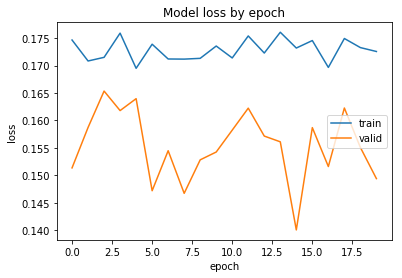

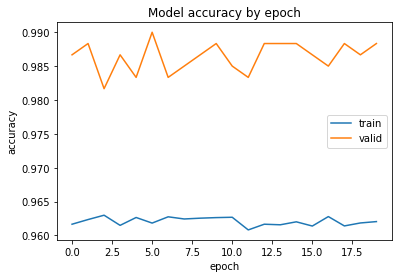

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

In [13]:
new_num_epochs = 30

for epch in range(new_num_epochs):
    history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=1,shuffle =True,
          verbose=1, validation_split=validation_proba) # ...holding out 10% of the data for validation

# EVALUATE THE MODEL ON TEST SET
   
    print("\n EVALUATION [loss, accuracy] on TEST set:")
    lossAndAcc = model.evaluate(X_test, Y_test, verbose=1)
    print(lossAndAcc) # Evaluate the trained model on the test set!
    if lossAndAcc[1] > 0.99:
        print("Accuracy := ",lossAndAcc[1]," in ",(epch+70)," epochs ")

Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 46s 773us/step - loss: 0.1876 - acc: 0.9586 - val_loss: 0.1637 - val_acc: 0.9833

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================] - 4s 399us/step
[0.10148891202807427, 0.9829]
Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 43s 721us/step - loss: 0.1881 - acc: 0.9576 - val_loss: 0.1720 - val_acc: 0.9817

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================] - 4s 384us/step
[0.09644952821731567, 0.9851]
Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 43s 720us/step - loss: 0.1841 - acc: 0.9587 - val_loss: 0.1553 - val_acc: 0.9850

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================] - 4s 403us/step
[0.09831350386738777, 0.9844]
Train on 59400 samples, validate on 600 

10000/10000 [==============================] - 4s 444us/step
[0.1014069131553173, 0.984]
Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 50s 848us/step - loss: 0.1842 - acc: 0.9599 - val_loss: 0.1661 - val_acc: 0.9833

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================] - 5s 476us/step
[0.0983426892876625, 0.9848]
Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 50s 844us/step - loss: 0.1820 - acc: 0.9594 - val_loss: 0.1598 - val_acc: 0.9800

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================] - 5s 452us/step
[0.09665588477849961, 0.9848]
Train on 59400 samples, validate on 600 samples
Epoch 1/1
59400/59400 [==============================] - 49s 829us/step - loss: 0.1846 - acc: 0.9589 - val_loss: 0.1396 - val_acc: 0.9867

 EVALUATION [loss, accuracy] on TEST set:
10000/10000 [==============================

We achieve this result in epochs, with the following parameters : 

Dropout_rate_1: 0.1, Dropout_rate_2 : 0.1, Weight_penalty: 0.01, Validation_split : 0.01. 



We are now going to compare this model with another one. For this new model, we add 2 layers of batchNormalization after the convolution/before the activation function. 
We also twist several parameters such as the conv_depth ( before : (6,16) ---> now : (32,64) ).
We could add a third conv layer, but the results I got were pretty similar. 

With the following parameters :
Dropout_rate_1: 0.4, Dropout_rate_2 : 0.4, Weight_penalty: 0.001, Validation_split : 0. 
num_epochs : 


We achieve xx.xx% accuracy. 

In [14]:
## We now twist a little bit our model : 
# ===================================

# We add another layer of conv + pooling, using average pooling 
# We also add Batch Normalization in every conv. layer 
# Our dense layer is now significantly bigger 

import os
# FIRST CHOOSE WHICH "BACK-END" YOU WILL USE, BETWEEN tensorflow (preferable) OR theano
#    (depending on which you have managed to install)
os.environ['KERAS_BACKEND']="tensorflow"
import tensorflow
print("Version tensorflow :" + tensorflow.__version__)
#os.environ['KERAS_BACKEND']="theano"
#import theano
#print("Version Theano :" + theano.__version__)


# WHATEVER BACK-END YOU HAVE CHOSEN, YOU SHALL USE keras AS RONT-END
import keras
print("Version KERAS :" + keras.__version__)

from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D,AveragePooling2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

from keras import regularizers


from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
from numpy import newaxis

# New Parameters 
# ==============
num_epochs = 20 # we iterate 50 times over the entire training set
drop_prob_1 = 0.4# dropout after pooling with probability 1/2
drop_prob_2 = 0.4 # dropout in the FC layer with probability 1/2
validation_proba = 0.2 # validation_split := 0.1
weight_penalty = 0.001 # Factor for weights penalty
hidden_size = 128 # the FC layer will have 512 neurons

# CONVNET PARAMETERS
# ===================
batch_size = 32 # in each iteration, we consider 32 training examples at once
kernel_size = 5 # we will use 5x5 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 64 # ...switching to 16 after the first pooling layer



# DATASET CHARACTERISTICS
num_train = 60000 # there are 60000 training examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 and *greyscale*
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

# REFORMAT PROPERLY THE DATA
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range
X_train = X_train[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels
print("Checking the shape of our train set : ")
print(X_train.shape)
print(Y_train.shape)


# NOW, BUILD THE MODEL ARCHITECTURE
# =================================

model = Sequential()
# FIRST CONVOLUTION+POOLING LAYERS
#   Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='linear', 
                         data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)


# Third CONVOLUTION+POOLING LAYERS
#    Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='linear') )
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) ) # Some Dropout regularization (if necessary)

# CLASSIFICATION PART: FULLY-CONNECTED LAYER + OUTPUT LAYER
#   Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) ) # Some Dropout regularization (if necessary)
model.add( Dense(num_classes, activation='softmax') )

# DISPLAY THE MODEL ARCHITECTURE INFORMATION
print(model.summary)

# DEFINE THE LOSS FUNCTION AND OPTIMIZER
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# TRAIN THE MODEL

    
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,shuffle =True,
          verbose=1, validation_split=validation_proba,
           callbacks=[history]) # ...holding out 10% of the data for validation

# EVALUATE THE MODEL ON TEST SET
   
print("\n EVALUATION [loss, accuracy] on TEST set:")
lossAndAcc = model.evaluate(X_test, Y_test, verbose=1)
print(lossAndAcc) # Evaluate the trained model on the test set!




Version tensorflow :1.11.0
Version KERAS :2.2.4
Checking the shape of our train set : 
(60000, 1, 28, 28)
(60000, 10)
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0xb439584e0>>
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 232s 5ms/step - loss: 0.6486 - acc: 0.8734 - val_loss: 0.2856 - val_acc: 0.9742
Epoch 2/20
48000/48000 [==============================] - 246s 5ms/step - loss: 0.3559 - acc: 0.9516 - val_loss: 0.2571 - val_acc: 0.9792
Epoch 3/20
48000/48000 [==============================] - 243s 5ms/step - loss: 0.3247 - acc: 0.9594 - val_loss: 0.2495 - val_acc: 0.9839
Epoch 4/20
48000/48000 [==============================] - 236s 5ms/step - loss: 0.2995 - acc: 0.9659 - val_loss: 0.2361 - val_acc: 0.9849
Epoch 5/20
48000/48000 [==============================] - 232s 5ms/step - loss: 0.2828 - acc: 0.9675 - val_loss: 0.2267 - val_acc: 0.9861
Epoch 6/20
48000/48000 [=========================

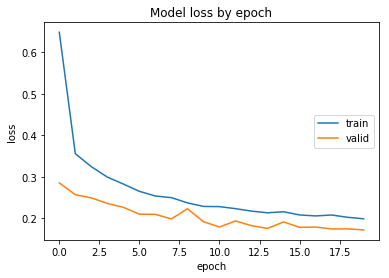

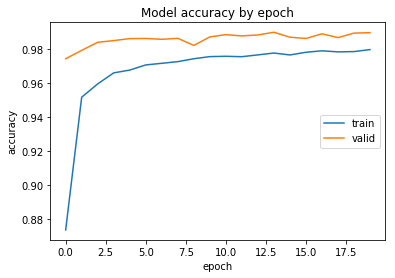

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()